<a href="https://colab.research.google.com/github/Mserna3/Integraci-n/blob/main/PARCIAL_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Contenido


**Caso de Estudio**: Integración de Eventos de Pérdida

Una empresa del sector FINTECH quiere caracterizar sus pérdidas en la colocación de créditos utilizando para ello información externa proveniente de empresas del sector.  

**Abstración**

Para la integración de bases de datos,  la FINTECH posee una base de datos interna (Datos Observados), así como **tres bases de Datos Externas provenientes de tres empresas similares del sector**.

Para la integración de bases de datos multivariable, se deben **seleccionar dos de las variables que tienen una mayor correlación sobre una variable de decisión (PreApr,Score,Prod.Default)** o la distribución de pérdida.

La distribución agregada de pérdidas puede obtenerse a partir del producto entre el Monto (EAD), la Prob.Default y la Garantia de un Crédito (LGD) (LDA – Normas NIIF-9).

Estimar las medidas de tendencia central para las variables de integración (media, desviación, asimetría) para antes y después de la integración.
Estimar el coeficiente de credibilidad general para la variable de decisión - distribución agregada de pérdidas (LDA) para cada base de datos externa.  


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew #coeficiente de asimetria
from sklearn.cluster import KMeans

In [4]:
nlx='/content/drive/MyDrive/Integración y Prospesctiva /PARCIALES/1. DB_Fintechs (USD).xlsx'
df=pd.read_excel(nlx,sheet_name=4)  #observable
dc=pd.read_excel(nlx,sheet_name=5) #externa 1
da=pd.read_excel(nlx,sheet_name=6) #externa 2
db=pd.read_excel(nlx,sheet_name=7) #externa 3
# If the sheet is actually named 4, make sure it exists in the Excel file
df.head()
dc.head()
da.head()
db.head()

,Monto (EAD),Prob.Default (PD),LGD
0,490.409628,0.144013,0.303595
1,974.824904,0.086007,0.557566
2,462.887434,0.124138,0.759336
3,1177.188187,0.006857,0.088882
4,244.151411,0.260362,0.315913


In [5]:
df.dropna(inplace=True)
dc.dropna(inplace=True)
da.dropna(inplace=True)
db.dropna(inplace=True)

In [6]:
df['LDA'] = df['Monto (EAD)'] * df['Prob.Default (PD)'] * df['LGD'] # Calculate 'LDA' as a Series
dc['LDA']=dc['Monto (EAD)']*dc['Prob.Default (PD)']*dc['LGD']
da['LDA']=da['Monto (EAD)']*da['Prob.Default (PD)']*da['LGD']
db['LDA']=db['Monto (EAD)']*db['Prob.Default (PD)']*db['LGD']

la corelación entre las variables en es:
                    Monto (EAD)  Prob.Default (PD)       LGD       LDA
Monto (EAD)           1.000000          -0.803208 -0.023829  0.016120
Prob.Default (PD)    -0.803208           1.000000  0.009794 -0.049677
LGD                  -0.023829           0.009794  1.000000  0.784978
LDA                   0.016120          -0.049677  0.784978  1.000000


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


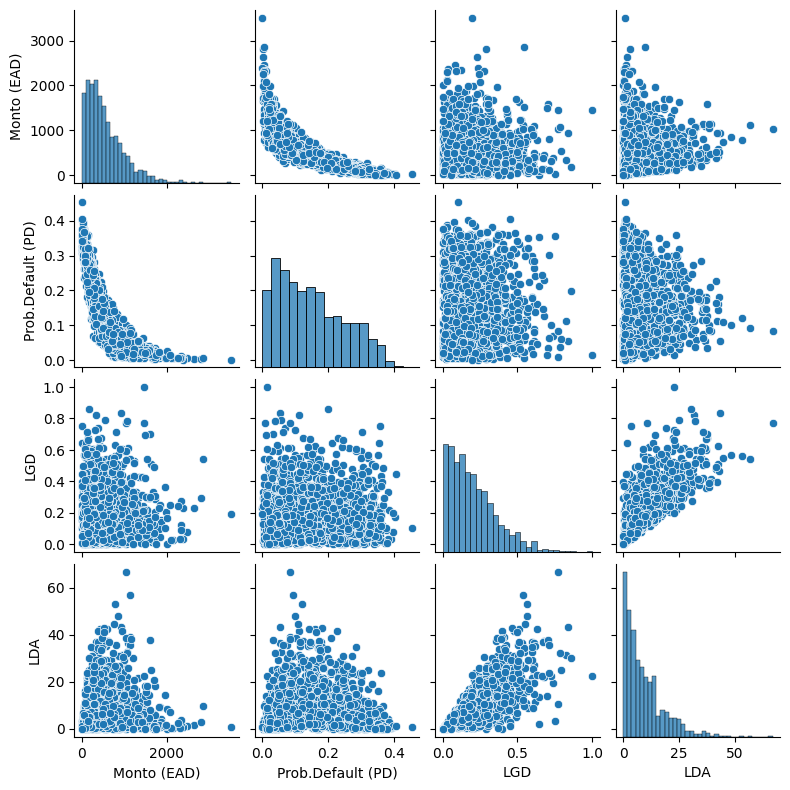

In [7]:
#voy a buscar que variable tiene mayor correlación con la variable de salida.
df.corr()

print('la corelación entre las variables en es:\n', df.corr())

sns.pairplot(df,size=2, vars=df.columns)

In [8]:
#las variables de trabajo son:
Xf= np.array(df.iloc[:,2])
Xs= np.array(df.iloc[:,0])
print("El numero de datos disponibles es:" , len(Xf))
print("El coeficiente de asimetria es: " ,skew(Xs))


El numero de datos disponibles es: 1500
El coeficiente de asimetria es:  1.5342143453970154


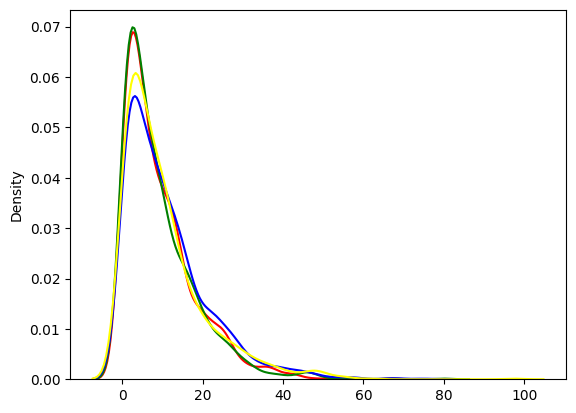

In [9]:
LDAo= np.array(df.iloc[:,3])
LDAc= np.array(dc.iloc[:,3])
LDAa= np.array(da.iloc[:,3])
LDAb= np.array(db.iloc[:,3])

plt.figure()
sns.kdeplot(LDAo, color='red')
sns.kdeplot(LDAc, color='green')
sns.kdeplot(LDAa, color='blue')
sns.kdeplot(LDAb, color='yellow')
plt.show()

In [10]:
#1. se determina el nunumero de los datos por cada base de datos
NDo=len(LDAo); NDc=len(LDAc); NDa=len(LDAa); NDb=len(LDAb)

#2. Se procede con el calculo de la EPV
varo=np.var(LDAo); varC=np.var(LDAc); varA=np.var(LDAa); varB=np.var(LDAb)
EPV=(NDo*varo+NDc*varC)/(NDo+NDc) #la varianza hipotetica.
EPV_2=(NDo*varo+NDa*varA)/(NDo+NDa)
EPV_3=(NDo*varo+NDb*varB)/(NDo+NDb)
print('El valor esperado de la varianza es:',EPV)
print('El valor esperado de la varianza es:',EPV_2)
print('El valor esperado de la varianza es:',EPV_3)

#3. se procede on la estimación del VHM

uo=np.mean(LDAo) ; uc=np.mean(LDAc); ua=np.mean(LDAa); ub=np.mean(LDAb)
uh=(uo*NDo +uc*NDc)/(NDo+NDc)
uh_2=(uo*NDo +ua*NDa)/(NDo+NDa)
uh_3=(uo*NDo +ub*NDb)/(NDo+NDb)
print('la media hipotetica de las bases de datos es:' , uh)
print('la media hipotetica 2 de las bases de datos es:' , uh_2)
print('la media hipotetica 3 de las bases de datos es:' , uh_3)

#3.1 se estima la VHM
PDo=NDo/(NDo+NDc); PDc=NDc/(NDo+NDc) ; PDa=NDo/(NDo+NDa); PDb=NDo/(NDo+NDb)
VHM=PDo*uo**2+PDc*uc**2-uh**2
PDo=NDo/(NDo+NDc)
VHM_2=PDo*uo**2+PDa*ua**2-uh_2**2
PDo=NDo/(NDo+NDb)
VHM_3=PDo*uo**2+PDb*ub**2-uh_3**2
print('el valor de la HMV es:' , VHM)
print('el valor de la HMV 2 es:' , VHM_2)
print('el valor de la HMV 3 es:' , VHM_3)

#4. factor de credebilidad
#si es muy grande las bases dedatos tiene diferentes magnitudes
#los datos son muy extendidos y hay mucha variedad en los mismos
FC=EPV/VHM
FC_2=EPV_2/VHM_2
FC_3=EPV_3/VHM_3
print('el factor de credebilidad es:' , FC)
print('el factor de credebilidad 2 es:' , FC_2)
print('el factor de credebilidad 3 es:' , FC_3)

#5. se procede con la estimación de la credibilidad
#cuando el factor de credibilidad es muy grande este le da una mayor importancia a la integración de los datos
ND=NDo+NDc
ND_2=NDo+NDa
ND_3=NDo+NDb
cred=ND/(ND+FC)
cred_2=ND_2/(ND_2+FC_2)
cred_3=ND_3/(ND_3+FC_3)
print('la credibilidad es:' , cred)
print('la credibilidad 2 es:' , cred_2)
print('la credibilidad 3 es:' , cred_3)

#6. Cual es el valor de asimetria proyectado
#La asimetria proyectada de la integración es:
CAsim_int=cred*skew(LDAo)+ (1-cred)*skew(LDAc)
CAsim_int_2=cred_2*skew(LDAo)+ (1-cred_2)*skew(LDAa)
CAsim_int_3=cred_3*skew(LDAo)+ (1-cred_3)*skew(LDAb)
print('la asimetria proyectada es:' , CAsim_int)
print('la asimetria proyectada 2 es:' , CAsim_int_2)
print('la asimetria proyectada 3 es:' , CAsim_int_3)

#6.1 La asimetria interna es:
print('el coefiente de asimetria interno es:', skew(LDAo))
print('el coefiente de asimetria externo 1 es:', skew(LDAc))
print('el coefiente de asimetria externo 2 es:', skew(LDAa))
print('el coefiente de asimetria externo 3 es:', skew(LDAb))

#6.2 La media proyectada de la integración de los datos es:
MProyec=cred*np.mean(LDAo)+ (1-cred)*np.mean(LDAc)
MProyec_2=cred_2*np.mean(LDAo)+ (1-cred_2)*np.mean(LDAa)
MProyec_3=cred_3*np.mean(LDAo)+ (1-cred_3)*np.mean(LDAb)
print('la media interna es:',np.mean(LDAo))
print('la media externa es:',np.mean(LDAc))
print('la media interna es:',np.mean(LDAa))
print('la media externa es:',np.mean(LDAb))
print('la media proyectada es:' , MProyec)
print('la media proyectada es:' , MProyec_2)
print('la media proyectada es:' , MProyec_3)

#6.3 La variable proyectada de los datos es:

print('la varianza interna es:',np.var(LDAo))
print('la varianza externa 1 es:',np.var(LDAc))
print('la varianza externa 2 es:',np.var(LDAa))
print('la varianza externa 3 es:',np.var(LDAb))
print('la varianza proyectada es:' , EPV)
print('la varianza proyectada es:' , EPV_2)
print('la varianza proyectada es:' , EPV_3)

#cuando la credibilidad de los datos internos es mayor que la de los datos externos no habria necesidad de integrar las bases de datos.


El valor esperado de la varianza es: 79.52656523062855
El valor esperado de la varianza es: 91.56398464658928
El valor esperado de la varianza es: 91.61676156699326
la media hipotetica de las bases de datos es: 9.251533243659145
la media hipotetica 2 de las bases de datos es: 10.189178149853744
la media hipotetica 3 de las bases de datos es: 9.830752514324105
el valor de la HMV es: 0.00831440865030686
el valor de la HMV 2 es: 0.701902697991045
el valor de la HMV 3 es: 6.251830498179032
el factor de credebilidad es: 9564.90937304284
el factor de credebilidad 2 es: 130.45110797929638
el factor de credebilidad 3 es: 14.654389877281291
la credibilidad es: 0.23882075788624813
la credibilidad 2 es: 0.9583283356041608
la credibilidad 3 es: 0.9948700865147672
la asimetria proyectada es: 1.8484878475061608
la asimetria proyectada 2 es: 1.5841142385264277
la asimetria proyectada 3 es: 1.5823560440735893
el coefiente de asimetria interno es: 1.5801153694130536
el coefiente de asimetria externo 1 

In [11]:
from sklearn.cluster import KMeans #Metodo k-means para clusterización

mkmf= KMeans(n_clusters=5, random_state=42)
mkmf.fit(Xf.reshape(-1,1)) #esto es para quitar la estructura a los datos. (reshape (-1,1))
XCf= mkmf.cluster_centers_
XCf=np.array(sorted(XCf, reverse=True))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
mkmf= KMeans(n_clusters=5, random_state=42)
mkmf.fit(Xs.reshape(-1,1)) #esto es para quitar la estructura a los datos. (reshape (-1,1))
XCs= mkmf.cluster_centers_
XCs=np.array(sorted(XCs))

#MAtriz de perdida
MP=XCf*XCs.reshape(1,5)
print("Matriz de perdida es:\n " ,MP)

Matriz de perdida es:
  [[ 111.34274509  318.3696817   574.47164175  901.7401448  1484.6101869 ]
 [  74.35888807  212.61929108  383.6538472   602.2161071   991.47872307]
 [  48.80387271  139.54814397  251.8030327   395.25171769  650.73594634]
 [  27.41705268   78.39539369  141.45797513  222.0446158   365.57061417]
 [   8.54227471   24.42549156   44.07377035   69.18198423  113.90008433]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


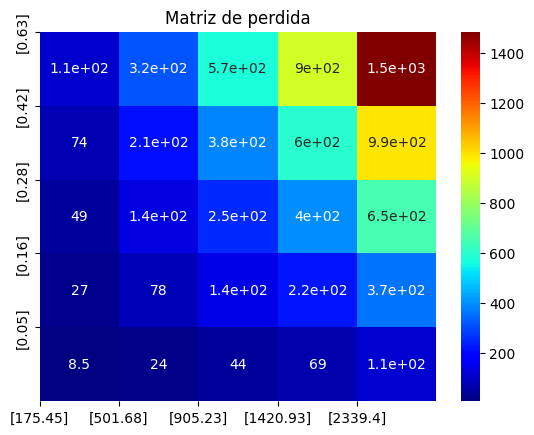

In [13]:
plt.figure()
sns.heatmap(MP, annot=True,cmap='jet')
plt.yticks(range(len(XCf)), np.round(XCf,2))
plt.xticks(range(len(XCs)),np.round(XCs,2))
plt.title("Matriz de perdida")
plt.show()

In [14]:
sigmaf= np.zeros((5,1))

for i in range(5):
  for j in range(5):
    sigmaf[i,]+=np.sqrt((XCf[i,]-XCf[j,])**2)
  sigmaf[i,]=sigmaf[i,]/4 #se divide entre el numero total de cluster menos 1. en este caso hay 5 cluster.
  #Esto se debe a que se divide por el numero de distancias desde el centroide.

  print("El tamaño de cada uno de los clusters es:\n",sigmaf)

  #severidad
  sigmas= np.zeros((5,1))

for i in range(5):
  for j in range(5):
    sigmas[i,]+=np.sqrt((XCs[i,]-XCs[j,])**2)
  sigmas[i,]=sigmas[i,]/4 #se divide entre el numero total de cluster menos 1. en este caso hay 5 cluster.
  #Esto se debe a que se divide por el numero de distancias desde el centroide.

  print("El tamaño de cada uno de los clusters es:\n",sigmas)

El tamaño de cada uno de los clusters es:
 [[0.40787767]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
El tamaño de cada uno de los clusters es:
 [[0.40787767]
 [0.24978215]
 [0.        ]
 [0.        ]
 [0.        ]]
El tamaño de cada uno de los clusters es:
 [[0.40787767]
 [0.24978215]
 [0.21336866]
 [0.        ]
 [0.        ]]
El tamaño de cada uno de los clusters es:
 [[0.40787767]
 [0.24978215]
 [0.21336866]
 [0.24384286]
 [0.        ]]
El tamaño de cada uno de los clusters es:
 [[0.40787767]
 [0.24978215]
 [0.21336866]
 [0.24384286]
 [0.3245272 ]]
El tamaño de cada uno de los clusters es:
 [[1116.36018943]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]]
El tamaño de cada uno de los clusters es:
 [[1116.36018943]
 [ 871.69054724]
 [   0.        ]
 [   0.        ]
 [   0.        ]]
El tamaño de cada uno de los clusters es:
 [[1116.36018943]
 [ 871.69054724]
 [ 770.80130073]
 [   0.        ]
 [   0.        ]]
El tamaño de cada uno de los clusters es:
 

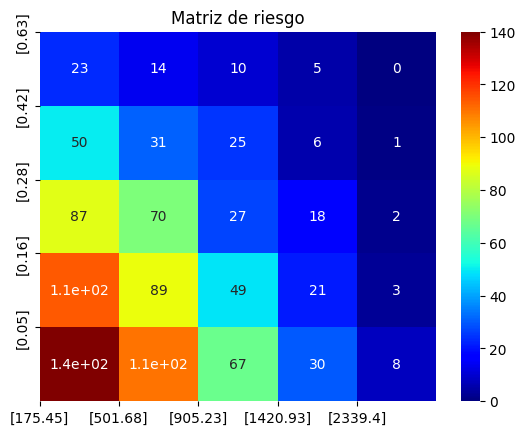

In [15]:
MEv=np.zeros((5,5))
XFk= 5 ; Xsk=10

XCff=np.array((XCf))
XCss=np.array((XCs))

for k in range(1000):
  VCf=np.exp(-0.5*((XCff-Xf[k,])/sigmaf)**2) #Valor de credebilidad- clusters del negocio
  fila=np.where(np.max(VCf)==VCf)[0]
  VCs=np.exp(-0.5*((XCss-Xs[k,])/sigmas)**2) #Valor de credebilidad -
  col=np.where(np.max(VCs)==VCs)[0] # Fixed indentation
  MEv[fila,col]+=1

plt.figure()
sns.heatmap(MEv, annot=True,cmap='jet')
plt.yticks(range(len(XCff)), np.round(XCff,2))
plt.xticks(range(len(XCss)),np.round(XCss,2))
plt.title("Matriz de riesgo")
plt.show()

In [17]:

#se crea la base de datos consolidada

#1 se llama los datos externos
Xfe= np.array(dc.iloc[:,2])
Xse= np.array(dc.iloc[:,0])
Xse # Changed to 1 as there are only 2 columns
print("El numero de datos disponibles es:" , len(Xfe))
XBC=np.zeros((1,2))

#2. se procede con la integración
MEve=np.zeros((5,5))

for k in range(len(Xfe)):
  VPfe=np.exp(-0.5*((XCff-Xfe[k,])/sigmaf)**2) #primer dato frecuencia
  fila_e=np.where(np.max(VPfe)==VPfe)[0]
  VPse=np.exp(-0.5*((XCss-Xse[k,])/sigmas)**2)#primer dato severidad
  VPT=np.max(VPfe)*np.max(VPse)  # Busco las maximas pertencias
  col_e=np.where(np.max(VPse)==VPse)[0]

  if VPT>0.9:
      MEve[fila_e, col_e]+=1
      arr1=np.array([Xfe[k,],Xse[k,]])
      XBC=np.vstack((XBC,arr1))

#2.1 Se crea el informa con los datos que cumplen
df2=pd.DataFrame(XBC)
df2.columns=['LGD', 'Monto']
df2.to_excel('Eventos Externos.xlsx')

print('El valor de pertenencia cojunta es:',VPT)
#print('La base de datos consolidada es:\n',XBC)
print('La matriz de eventos es:\n',MEve)

#3. se crea la base de datos total
XDBi=np.column_stack((Xf, Xs)) #los datos internos u observados
XBC=np.vstack((XDBi,XBC))
print('La base de datos consolidada es:\n',XBC)
print('el numero de datos en la base de datos es:',len(XBC))

#4. se procede con la validación de las distribuciones de perdidas
LDAi=XDBi[:,0]*XDBi[:,1]
LDAc=XBC[:,0]*XBC[:,1]
print("El coeficiente de asimetria de la distribución agregada  es: " ,skew(LDAi))
print("El coeficiente de asimetria de la distribución agregada es: " ,skew(LDAc))

#5. Se procede con la creación del informe final
df=pd.DataFrame(XBC)
df.columns=['LGD', 'Monto']
df.to_excel('Base de datos.xlsx')

El numero de datos disponibles es: 1501
El valor de pertenencia cojunta es: 0.9787605261647668
La matriz de eventos es:
 [[ 39.  21.  11.   5.   0.]
 [ 82.  55.  25.   9.   4.]
 [145.  91.  51.  18.   5.]
 [185. 149.  60.  27.   8.]
 [232. 144.  87.  31.  10.]]
La base de datos consolidada es:
 [[3.53998942e-01 2.50209001e+02]
 [2.72671152e-02 5.74469987e+02]
 [1.84123637e-01 1.46973987e+03]
 ...
 [7.41958903e-02 4.43412190e+01]
 [6.87765173e-02 7.38615188e+02]
 [2.02225376e-01 7.93306054e+01]]
el numero de datos en la base de datos es: 2995
El coeficiente de asimetria de la distribución agregada  es:  3.438709623237847
El coeficiente de asimetria de la distribución agregada es:  3.1032426051101063


In [18]:
ds=pd.read_excel('/content/Eventos Externos.xlsx')
ds.head()

,Unnamed: 0,Frecuencia,Severidad
0,0,0.000000,0.000000
1,1,0.353999,84.871944
2,2,0.027267,106.112376
3,3,0.184124,137.737842
4,4,0.458793,315.196041


In [19]:
Xe= np.array(ds.iloc[:,1])
Xr= np.array(ds.iloc[:,2])
print("El numero de datos disponibles es:" , len(Xe))

mkms= KMeans(n_clusters=5, random_state=42)
mkms.fit(Xe.reshape(-1,1)) #esto es para quitar la estructura a los datos. (reshape (-1,1))
XCS= mkms.cluster_centers_
XCS=np.array(sorted(XCS, reverse=True))

El numero de datos disponibles es: 1495


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [20]:

mkms= KMeans(n_clusters=5, random_state=42)
mkms.fit(Xr.reshape(-1,1)) #esto es para quitar la estructura a los datos. (reshape (-1,1))
XCh= mkmf.cluster_centers_
XCh=np.array(sorted(XCh))

#MAtriz de perdida
MP=XCS*XCh.reshape(1,5)
print("Matriz de perdida es:\n " ,MP)

Matriz de perdida es:
  [[ 101.45278438  290.09066235  523.44450064  821.64355122 1352.74046873]
 [  70.57239033  201.79230742  364.11745465  571.55010347  940.9907176 ]
 [  47.70816346  136.41510996  246.14973311  386.37781197  636.12609347]
 [  26.93560265   77.01875175  138.97393913  218.14545905  359.15110644]
 [   8.40426408   24.03086863   43.36170606   68.06426681  112.0598927 ]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


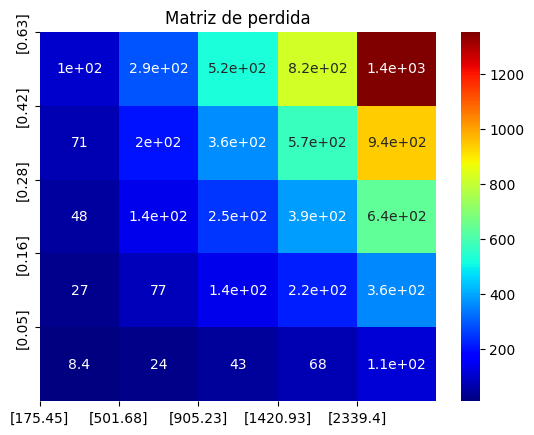

In [21]:
plt.figure()
sns.heatmap(MP, annot=True,cmap='jet')
plt.yticks(range(len(XCf)), np.round(XCf,2))
plt.xticks(range(len(XCs)),np.round(XCs,2))
plt.title("Matriz de perdida")
plt.show()

In [22]:
sigmaf= np.zeros((5,1))

for i in range(5):
  for j in range(5):
    sigmaf[i,]+=np.sqrt((XCS[i,]-XCS[j,])**2)
  sigmaf[i,]=sigmaf[i,]/4 #se divide entre el numero total de cluster menos 1. en este caso hay 5 cluster.
  #Esto se debe a que se divide por el numero de distancias desde el centroide.

  print("El tamaño de cada uno de los clusters es:\n",sigmaf)

  #severidad
  sigmas= np.zeros((5,1))

for i in range(5):
  for j in range(5):
    sigmas[i,]+=np.sqrt((XCh[i,]-XCh[j,])**2)
  sigmas[i,]=sigmas[i,]/4 #se divide entre el numero total de cluster menos 1. en este caso hay 5 cluster.
  #Esto se debe a que se divide por el numero de distancias desde el centroide.


El tamaño de cada uno de los clusters es:
 [[0.35934798]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
El tamaño de cada uno de los clusters es:
 [[0.35934798]
 [0.22734304]
 [0.        ]
 [0.        ]
 [0.        ]]
El tamaño de cada uno de los clusters es:
 [[0.35934798]
 [0.22734304]
 [0.19476367]
 [0.        ]
 [0.        ]]
El tamaño de cada uno de los clusters es:
 [[0.35934798]
 [0.22734304]
 [0.19476367]
 [0.22436261]
 [0.        ]]
El tamaño de cada uno de los clusters es:
 [[0.35934798]
 [0.22734304]
 [0.19476367]
 [0.22436261]
 [0.30357884]]


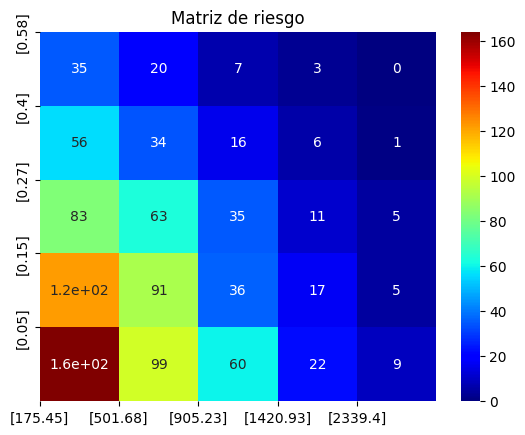

In [23]:
MEv=np.zeros((5,5))
XFk= 5 ; Xsk=10

XCff=np.array((XCS))
XCss=np.array((XCh))

for k in range(1000):
  VCf=np.exp(-0.5*((XCff-Xe[k,])/sigmaf)**2) #Valor de credebilidad- clusters del negocio
  fila=np.where(np.max(VCf)==VCf)[0]
  VCs=np.exp(-0.5*((XCss-Xr[k,])/sigmas)**2) #Valor de credebilidad -
  col=np.where(np.max(VCs)==VCs)[0]
  MEv[fila,col]+=1

plt.figure()
sns.heatmap(MEv, annot=True,cmap='jet')
plt.yticks(range(len(XCff)), np.round(XCff,2))
plt.xticks(range(len(XCss)),np.round(XCss,2))
plt.title("Matriz de riesgo")
plt.show()


#caso practico

Exposure at Default (EAD)
Caso de Estudio: Un prestatario recibe un crédito de USD 400,000 para la compra de un condo. Después de pagar las cuotas durante años, el prestatario empieza a tener dificultades financieras. Se espera que el prestatario tengo un 80% de impago. El saldo pendiente del crédito es de USD 300,000, y el banco podrá vender el condo por USD 200,000 en caso de ejecución hipotecaría.  
Exposure at Default (EAD): Representa el importe restante del crédito por pagar USD 300,000

Según las matrices de pérdida y riesgo presentadas, el prestatario representa un riesgo moderado para la empresa. Esto se debe a que el monto del préstamo se encuentra en el rango de los clusters de entre USD 175,000 a USD 501,000, con una probabilidad de recuperación de aproximadamente 33%. Esto sugiere que, para el banco, este cliente generaría una pérdida moderada a moderadamente baja en caso de incumplimiento.

En cuanto a la matriz de riesgo, el análisis sugiere que este tipo de prestatarios representa un riesgo bajo, lo cual indica que estos casos de incumplimiento no son muy frecuentes o que el banco tiene implementadas buenas estrategias de mitigación y planes de contingencia para gestionar este tipo de deudas.

En resumen, el prestatario no presenta un riesgo financiero crítico, pero se debe tener precaución ya que la recuperación esperada es limitada, y, aunque el riesgo sea bajo, las pérdidas potenciales no son insignificantes. El banco debe valorar si las estrategias actuales son suficientes para minimizar la pérdida asociada a este tipo de créditos.



¿Cuál es la entidad financiera que aporto la mayor cantidad de datos de integración para un nivel de confianza del 95%?

¿Qué valor toma el coeficiente de asimetría para antes y despues de la integración de los datos a la base de datos interna (Datos Observados)?

Es importante relacionar los coeficientes de la base de datos interna y la base de datos externa que más datos aporta a dicha base de datos.

1. La entidad que aporto la mayor cantidad de datos con un 95% de confianza es la base externa 2.

2. antes de la integración es 1.58 y despues de la integración es de 3.43

3. estas dos bases muestran una distribución de asimetria bastante parecido por lo que podemos decir que los datos en ambas bases de datos estan altamente correlacionados. por lo que podemos decir que las variables escogidas para la integración que son Monto y LGD, son parecidas y presentan una alta confiabilidad para la el uso de predicciones esperadas por la empresa.